In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib
import matplotlib.cm as cm

# special imports for scaling maps!
import copy
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set such that PDF fonts export in a manner that they
# are editable in illustrator/affinity
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# set to define axes linewidths
matplotlib.rcParams['axes.linewidth'] = 0.5

# this defines some prefactors so inline figures look nice
# on a retina macbook. These can be commented out without any
# issue and are solely asthetic.
%matplotlib inline
%config InlineBackend.figure_format='retina'

from afrc import AnalyticalFRC
from scipy import integrate


In [2]:
full_dm = np.loadtxt('data/FRC_A101_distance_map.csv', delimiter=',')

A100=AnalyticalFRC('A'*101)

In [3]:
AFRC_distance_map = A100.get_distance_map()

ratio_map = full_dm - AFRC_distance_map
 

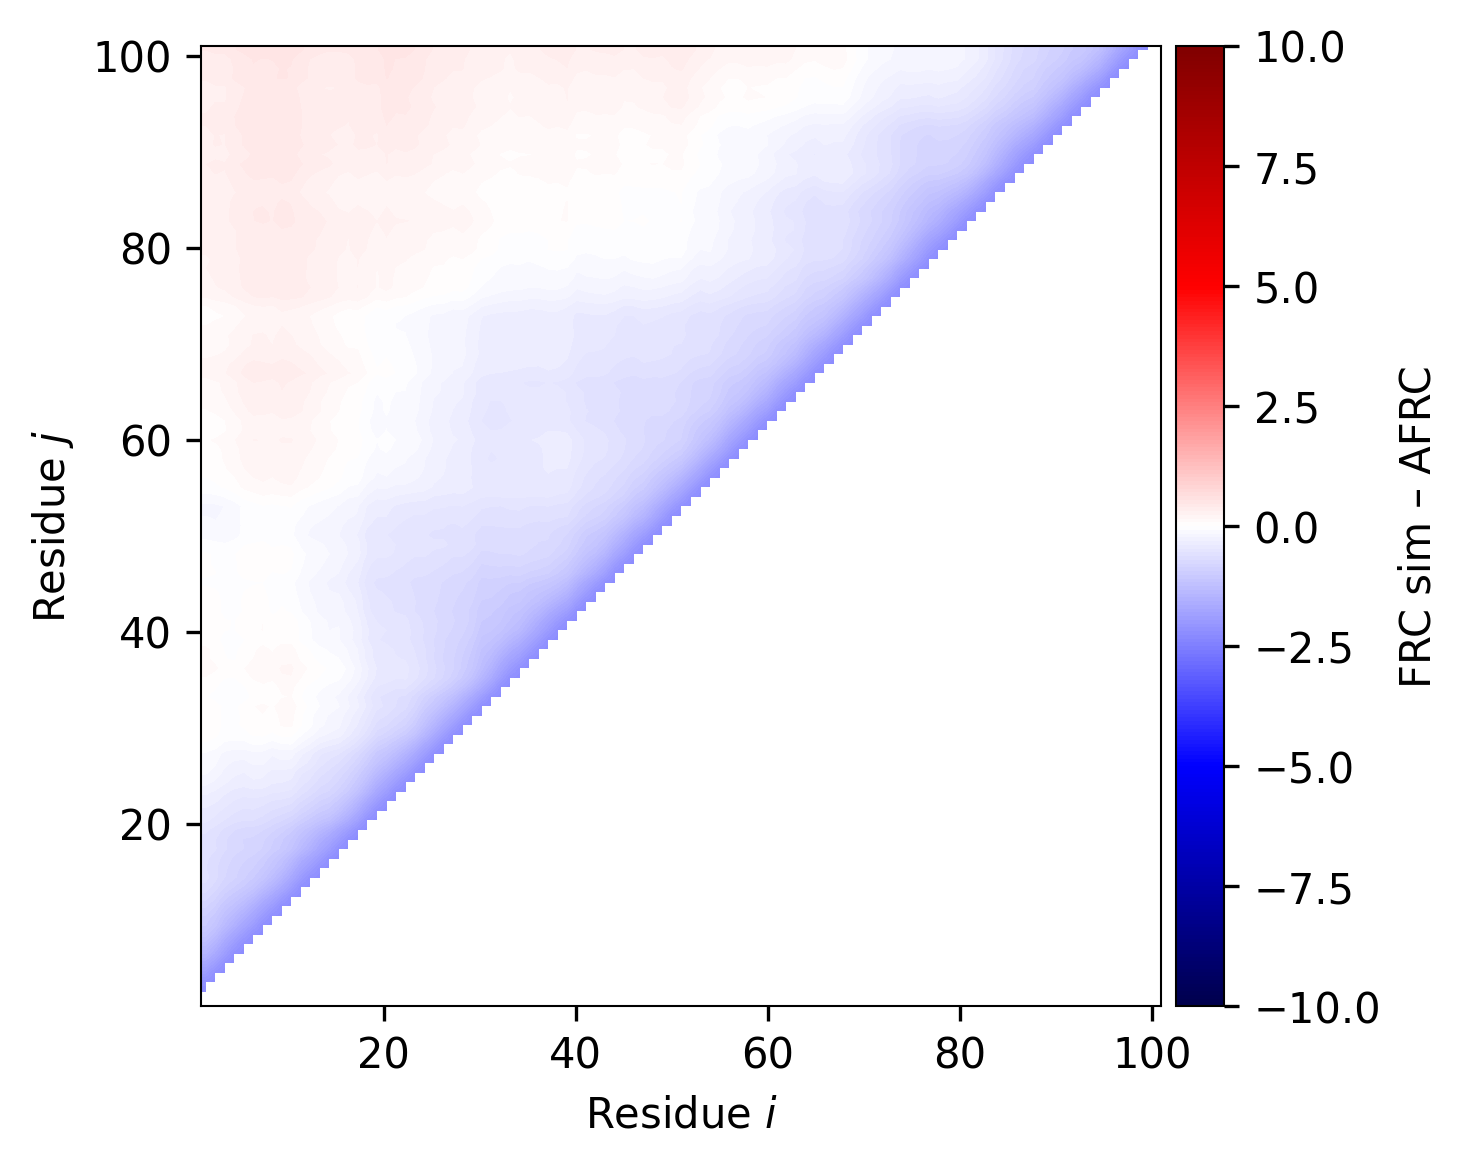

In [4]:
fig = figure(num=None, figsize=(5, 5), dpi=150, facecolor='w', edgecolor='k')
ax_list = fig.axes


# we define max extent for using plt.imshow. This basically sets the number of residues
max_extent = ratio_map.shape[0]


# transpose this so the final figures follow convention
ratio_map_tranposed = ratio_map.transpose()

# we build a masked array for figure generation
masked_array = np.ma.masked_where(ratio_map_tranposed == 0, ratio_map_tranposed)

## By convention we also want to create a color map that is reflective around 0 but also
# shows the 'bad' values as white. Bad here just reflects values where we don't have data (i.e.) bottom
# right triangle of the evntual figure
# create a copy of the colormap

# the defauly colourmap we use s seismic, but, there are MANY possible options - see
# https://matplotlib.org/3.1.0/tutorials/colors/colormaps.html
cmap = copy.copy(matplotlib.cm.get_cmap("seismic"))
cmap.set_bad(color='white')

# generate the figure! The main thing you may want to mess with here are vmax and vmin, which define the range
# over which the color scheme is defined. In a perfect world white = 1.0 and blue < 1 and red > 1, BUT sometims
# this isn't feasible, in which case a linear color map (i.e. blue to red) might be preferable. Use your discretion 
# here as needed!


im = plt.imshow(masked_array,cmap=cmap, interpolation='bilinear',
                   origin='lower', extent=[1, max_extent, 1, max_extent],
                    vmin=-10, vmax=10)


plt.xlabel('Residue $i$')
plt.ylabel('Residue $j$')

# by defaulty we show tickmarks every 20 residues, but, YMMV in terms of what works best for your data
plt.xticks(np.arange(0, ratio_map.shape[0]+1, 20),fontsize=10)
plt.yticks(np.arange(0, ratio_map.shape[0]+1, 20),fontsize=10)

plt.xlim([1,max_extent])
plt.ylim([1,max_extent])


ax = plt.gca()
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
cb = plt.colorbar(cax=cax)
cb.set_label('FRC sim – AFRC')

# include this to stop matplotlib being dumb and chopping off axes info...
plt.tight_layout()
plt.savefig('subraction.pdf')


In [5]:
from soursop.sstrajectory import SSTrajectory
A100_FRC = SSTrajectory('data/FRC_A101.xtc','data/FRC_A101.pdb').proteinTrajectoryList[0]

def dist2contact(distvector, threshold):
    
    bin_width=0.2
    max_val=120
    bins = np.arange(0,max_val, bin_width)

    [counts, b] = np.histogram(distvector, bins, density=True)
    plot_bins = bins[1:]



    # build a list where of truth values where each element is true or false (true if val < thresh)
    t = plot_bins <= threshold

    # find largest index from the truth vals
    all_vals = [i for i, x in enumerate(t) if x]
    idx_max = max(all_vals)+1

    xval = plot_bins[:idx_max]
    yval = counts[:idx_max]
    dx = xval[1]-xval[0]
    area_under_curve = integrate.simps(yval, xval)/dx

    return area_under_curve*bin_width
    
    

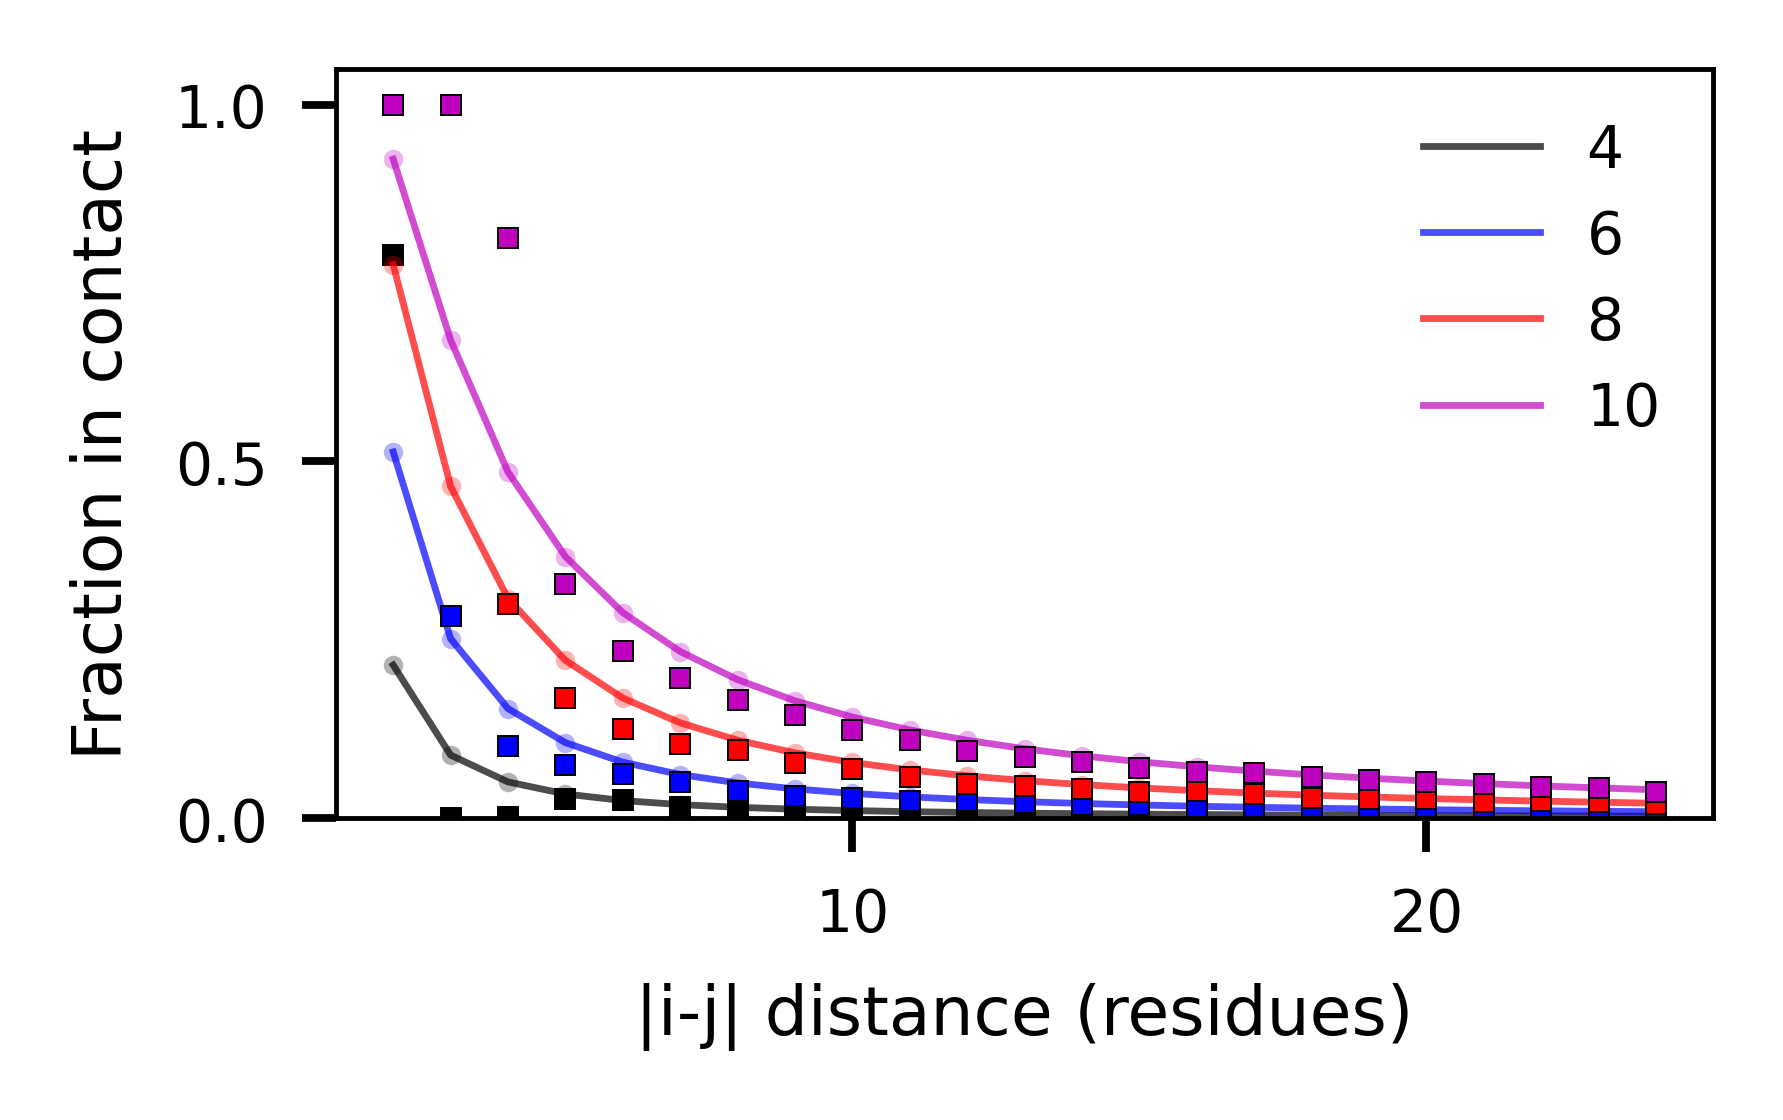

In [6]:
figure(None, (2.7,1.7), dpi=350)


max_dist=25
contact_distances = list(range(2,max_dist))


colors = {4:'k',6:'b',8:'r',10:'m'}

for thresh in [4,6,8,10]:
    contact_fractions = []
    contact_fractions_sim = []
    for i in contact_distances:
        contact_fractions.append(A100.get_contact_fraction(1,i,thresh))
        
        
        contact_fractions_sim.append(dist2contact(A100_FRC.get_inter_residue_COM_distance(1,i),thresh))
        
    plt.plot(contact_distances, contact_fractions, '-',linewidth=0.7, color=colors[thresh], alpha=0.7, label=f'{thresh}')
    plt.plot(contact_distances, contact_fractions, '.',ms=4, color=colors[thresh], alpha=0.3,mew=0)
    
    plt.plot(contact_distances, contact_fractions_sim, 's',ms=2, color=colors[thresh], alpha=1,mew=0.2, mec='k')
    
    
    

plt.xlim([1, max_dist])  
plt.ylim([0,1.05])  
plt.xticks(fontsize=6)
plt.yticks(fontsize=6)
plt.legend(frameon=False, fontsize=6)
plt.xlabel('|i-j| distance (residues)',fontsize=7)
plt.ylabel('Fraction in contact', fontsize=7)

plt.tight_layout()
plt.savefig('contact_fraction.pdf')


